In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3

## Pre-processing

In [133]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
classes = ['fire', 'non-fire']

In [134]:
datagen = ImageDataGenerator(rescale=1./255)

In [135]:
train_ds = datagen.flow_from_directory(
    'imgs/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='binary')

val_ds = datagen.flow_from_directory(
    'imgs/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'imgs/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='binary',
    shuffle=False)

Found 2483 images belonging to 2 classes.
Found 310 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


In [171]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

## Pre-Trained Models

### VGG16

In [74]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_vgg16 = tf.keras.Model(inputs, x)

In [69]:
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 1024)              525312    
                                                                 
 dense_5 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 15,241,025
Trainable params: 526,337
Non-trainable params: 14,714,688
_________________________________________

In [60]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [61]:
history1 = model_vgg16.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8550
Epoch 1: val_accuracy improved from -inf to 0.85806, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 21s 262ms/step - loss: 0.3290 - accuracy: 0.8550 - val_loss: 0.3632 - val_accuracy: 0.8581 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.2201 - accuracy: 0.9154
Epoch 2: val_accuracy improved from 0.85806 to 0.90645, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 21s 265ms/step - loss: 0.2201 - accuracy: 0.9154 - val_loss: 0.2361 - val_accuracy: 0.9065 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9211
Epoch 3: val_accuracy improved from 0.90645 to 0.91290, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 20s 264ms/step - loss: 0.1859 - accuracy: 0.9211 - val_loss: 0.1974 - val_accurac

In [96]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

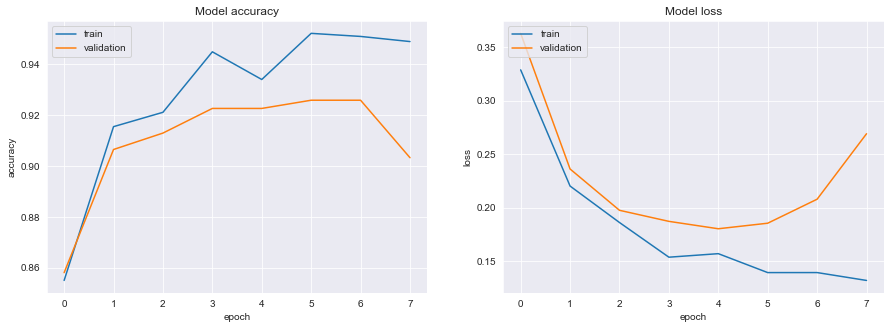

In [82]:
plot_train_history(history1)

## Fine Tuning

In [97]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

model_vgg16.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              525312    
                                                                 
 dense_7 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 15,241,025
Trainable params: 15,241,025
Non-trainable params: 0
_______________________________________________

In [98]:
history2 = model_vgg16.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9629
Epoch 1: val_accuracy improved from 0.92581 to 0.95806, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 24s 296ms/step - loss: 0.1058 - accuracy: 0.9629 - val_loss: 0.1312 - val_accuracy: 0.9581 - lr: 1.0000e-05
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.0336 - accuracy: 0.9907
Epoch 2: val_accuracy improved from 0.95806 to 0.96129, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 23s 298ms/step - loss: 0.0336 - accuracy: 0.9907 - val_loss: 0.0835 - val_accuracy: 0.9613 - lr: 1.0000e-05
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.0149 - accuracy: 0.9976
Epoch 3: val_accuracy improved from 0.96129 to 0.97419, saving model to saved_models\model_vgg16.hdf5
78/78 [==============================] - 24s 309ms/step - loss: 0.0149 - accuracy: 0.9976 - val_loss: 0.0843 - 

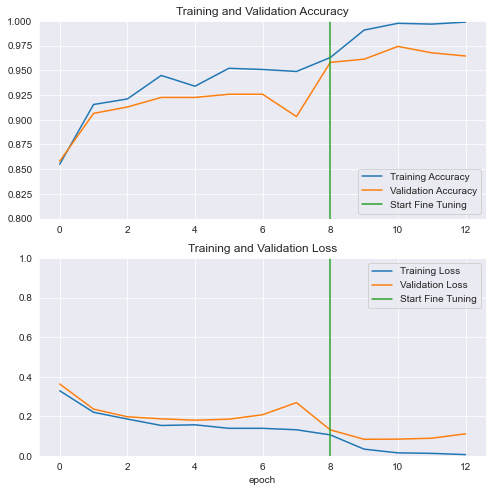

In [107]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([8,8],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history1.history['loss'] + history2.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'] + history2.history['val_loss'], label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([8,8],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [99]:
score1 = model_vgg16.evaluate(val_ds, verbose=1)
print(f'Model 1 VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')

10/10 [==============================] - 2s 213ms/step - loss: 0.1113 - accuracy: 0.9645
Model 1 VGG16 Loss: 0.11134855449199677, Accuracy: 96.45161032676697


### InceptionV3

In [8]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
inception.trainable = False
inputs = tf.keras.Input(input_shape)
x = inception(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_inceptionv3 = tf.keras.Model(inputs, x)

In [9]:
model_inceptionv3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_inceptionv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23,901,985
Trainable params: 2,099,201
Non-trainable params: 21,802,784
_________________________________________

In [149]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_inceptionv3.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [150]:
history3 = model_inceptionv3.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9428
Epoch 1: val_accuracy improved from -inf to 0.96774, saving model to saved_models\model_inceptionv3.hdf5
78/78 [==============================] - 24s 278ms/step - loss: 0.2130 - accuracy: 0.9428 - val_loss: 0.1042 - val_accuracy: 0.9677 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.0530 - accuracy: 0.9843
Epoch 2: val_accuracy improved from 0.96774 to 0.97097, saving model to saved_models\model_inceptionv3.hdf5
78/78 [==============================] - 20s 263ms/step - loss: 0.0530 - accuracy: 0.9843 - val_loss: 0.1287 - val_accuracy: 0.9710 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9875
Epoch 3: val_accuracy improved from 0.97097 to 0.98065, saving model to saved_models\model_inceptionv3.hdf5
78/78 [==============================] - 20s 263ms/step - loss: 0.0383 - accuracy: 0.9875 - val_loss: 0.

In [151]:
model_inceptionv3.load_weights('saved_models/model_inceptionv3.hdf5')

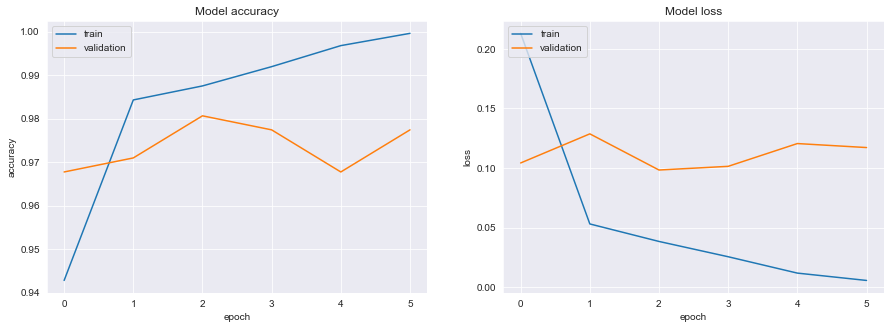

In [152]:
plot_train_history(history3)

## Fine Tuning

In [10]:
inception.trainable=True

model_inceptionv3.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

model_inceptionv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 23,901,985
Trainable params: 23,867,553
Non-trainable params: 34,432
____________________________________________

In [154]:
history4 = model_inceptionv3.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9903
Epoch 1: val_accuracy did not improve from 0.98065
78/78 [==============================] - 26s 280ms/step - loss: 0.0291 - accuracy: 0.9903 - val_loss: 0.0870 - val_accuracy: 0.9806 - lr: 1.0000e-05
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9992
Epoch 2: val_accuracy did not improve from 0.98065
78/78 [==============================] - 21s 266ms/step - loss: 0.0044 - accuracy: 0.9992 - val_loss: 0.0900 - val_accuracy: 0.9806 - lr: 1.0000e-05
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 6.7289e-04 - accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.98065 to 0.98710, saving model to saved_models\model_inceptionv3.hdf5
78/78 [==============================] - 21s 271ms/step - loss: 6.7289e-04 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9871 - lr: 1.0000e-05
Epoch 4/100
78/78 [==============================]

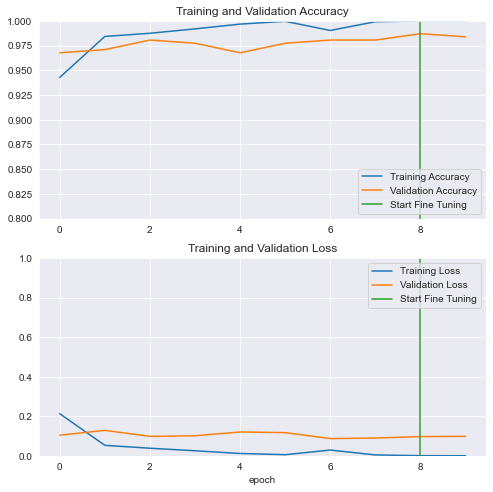

In [156]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history3.history['accuracy'] + history4.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'] + history4.history['val_accuracy'], label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([8,8],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history3.history['loss'] + history4.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'] + history4.history['val_loss'], label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([8,8],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [172]:
model_inceptionv3.load_weights('saved_models/model_inceptionv3.hdf5')

In [173]:
score2 = model_inceptionv3.evaluate(val_ds, verbose=1)
print(f'Model 2 InceptionV3 Loss: {score2[0]}, Accuracy: {score2[1]*100}')

10/10 [==============================] - 2s 185ms/step - loss: 0.0971 - accuracy: 0.9871
Model 2 InceptionV3 Loss: 0.09714408218860626, Accuracy: 98.70967864990234


## ResNet50

In [193]:
resnet = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
resnet.trainable=False
inputs = tf.keras.Input(input_shape)
x = resnet(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_resnet50 = tf.keras.Model(inputs, x)

In [194]:
model_resnet50.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_resnet50.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_35 (Dense)            (None, 1)                 1025      
                                                          

In [195]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_resnet50.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [196]:
history5 = model_resnet50.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.6573
Epoch 1: val_accuracy improved from -inf to 0.63548, saving model to saved_models\model_resnet50.hdf5
78/78 [==============================] - 24s 279ms/step - loss: 0.6536 - accuracy: 0.6573 - val_loss: 0.6641 - val_accuracy: 0.6355 - lr: 0.0010
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.6036 - accuracy: 0.6875
Epoch 2: val_accuracy improved from 0.63548 to 0.73226, saving model to saved_models\model_resnet50.hdf5
78/78 [==============================] - 21s 267ms/step - loss: 0.6036 - accuracy: 0.6875 - val_loss: 0.5357 - val_accuracy: 0.7323 - lr: 0.0010
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.5767 - accuracy: 0.7157
Epoch 3: val_accuracy improved from 0.73226 to 0.73548, saving model to saved_models\model_resnet50.hdf5
78/78 [==============================] - 22s 277ms/step - loss: 0.5767 - accuracy: 0.7157 - val_loss: 0.5321 - va

In [197]:
model_resnet50.load_weights('saved_models/model_resnet50.hdf5')

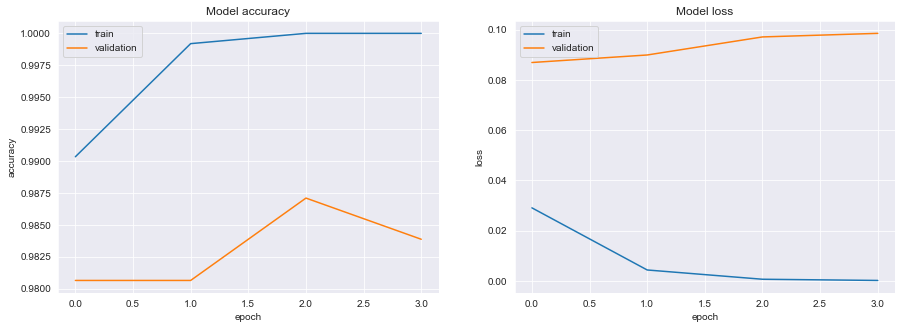

In [198]:
plot_train_history(history4)

## Fine Tuning

In [199]:
resnet.trainable=True

model_resnet50.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['accuracy'])

model_resnet50.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_17  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                                                                 
 dense_34 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_35 (Dense)            (None, 1)                 1025      
                                                          

In [200]:
history6 = model_resnet50.fit(train_ds, epochs = 100, validation_data = val_ds, callbacks=callbacks)

Epoch 1/100
78/78 [==============================] - ETA: 0s - loss: 0.7397 - accuracy: 0.6476
Epoch 1: val_accuracy did not improve from 0.81935
78/78 [==============================] - 27s 296ms/step - loss: 0.7397 - accuracy: 0.6476 - val_loss: 0.5363 - val_accuracy: 0.7548 - lr: 1.0000e-05
Epoch 2/100
78/78 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.7551
Epoch 2: val_accuracy did not improve from 0.81935
78/78 [==============================] - 23s 292ms/step - loss: 0.5206 - accuracy: 0.7551 - val_loss: 0.4675 - val_accuracy: 0.7935 - lr: 1.0000e-05
Epoch 3/100
78/78 [==============================] - ETA: 0s - loss: 0.4875 - accuracy: 0.7672
Epoch 3: val_accuracy did not improve from 0.81935
78/78 [==============================] - 23s 292ms/step - loss: 0.4875 - accuracy: 0.7672 - val_loss: 0.4729 - val_accuracy: 0.7839 - lr: 1.0000e-05
Epoch 4/100
78/78 [==============================] - ETA: 0s - loss: 0.4446 - accuracy: 0.8039
Epoch 4: val_accurac

In [201]:
model_resnet50.load_weights('saved_models/model_resnet50.hdf5')

In [202]:
score3 = model_resnet50.evaluate(val_ds, verbose=1)
print(f'Model 3 ResNet50 Loss: {score3[0]}, Accuracy: {score3[1]*100}')

10/10 [==============================] - 2s 207ms/step - loss: 0.3569 - accuracy: 0.8516
Model 3 ResNet50 Loss: 0.35693252086639404, Accuracy: 85.161292552948


## Training Result

In [280]:
print(f'VGG16 Loss: {score1[0]}, Accuracy: {score1[1]*100}')
print(f'InceptionV3 Loss: {score2[0]}, Accuracy: {score2[1]*100}')
print(f'ResNet50 Loss: {score3[0]}, Accuracy: {score3[1]*100}')

VGG16 Loss: 0.11134855449199677, Accuracy: 96.45161032676697
InceptionV3 Loss: 0.09714408218860626, Accuracy: 98.70967864990234
ResNet50 Loss: 0.35693252086639404, Accuracy: 85.161292552948
